In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
import numpy as np # linear algebra
import pandas as pd # data analysis
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("datasets/titanic_train.csv", header=0) # read csv

data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #extract the Salutations

# Assigning the NaN Values the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


# Age Feature Engineering

The age attribute is problematic in machine learning. For instance, given a sample of 30 individual, we could end up with 30 unique age values. Hence, given that the age affects the survival rate, we need to handle this feature.

We will divide the age values into groups.

We have already observed that the minimum age is 0.4 and the maximum is 80. A simple grouping is into 5 categories (80/5=16, i.e. per 16 years). Another grouping could be based on official surveys (e.g. [0-2, 3-16, 17-30, 31-45, 45+] ή [0-13, 14-25, 36-45, 46-55, 56-65, 65+]). 

In the Titanic dataset, we will follow the first approach.

In [5]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


In [6]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band

,Age_band
1,382
2,324
0,105
3,69
4,11


The Parch and SibSp attributes show the number of members of a family on-board. Hence, we can combine these feature and generate two new characteristics.

1. Family size: It will contain the number of members of the family.
2. Alone: It will denote whether a passenger travels alone or not.

In [7]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Family_Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2,0,1


Another feature similar to the age attribute is the Fare amount. 

It is observed that the lower amount is 0 and the higher is 512. A simple approach is to divide the amount into 5 groups. 

In [8]:
data['Fare_Range']=pd.qcut(data['Fare'],5)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


In [9]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

In [10]:
# string to int conversions
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [11]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Family_Size,Alone,Fare_Range,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1,0,"(-0.001, 7.854]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,2,1,0,"(39.688, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,2,1,0,1,"(7.854, 10.5]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,2,1,0,"(39.688, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,2,0,1,"(7.854, 10.5]",1


# Feature Elimination

1. Name: We cannot transform the name attribute into numeric.
2. Age: We have included a generated age group feature.
3. Ticket: It is a random identifier.
4. Fare: We have included a generate fare group feature.
5. Cabin: The are multiple null values.
6. Initial: We have included this feature to handle null values in the age attribute. We do not need this characterstic.
7. Fare_Range: We have included a generate fare group feature.
8. PassengerId: It is an identifier.

In [12]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Initial','Fare_Range','PassengerId'],axis=1,inplace=True)

In [13]:
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,1,1,0,0
1,1,1,1,1,0,1,2,1,0,3
2,1,3,1,0,0,0,1,0,1,1
3,1,1,1,1,0,0,2,1,0,3
4,0,3,0,0,0,0,2,0,1,1


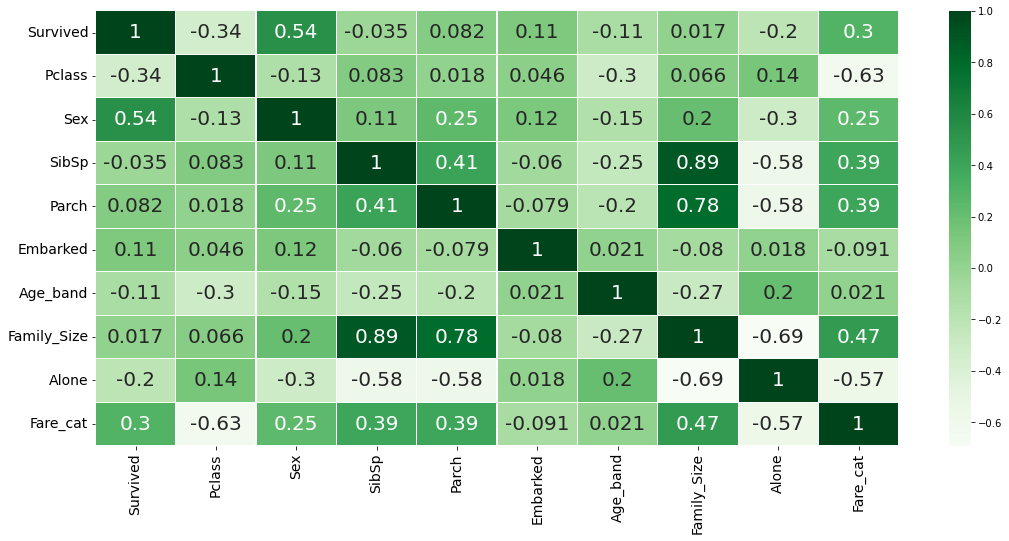

In [14]:
sns.heatmap(data.corr(),annot=True,cmap='Greens',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]].to_numpy()
train_Y=train[train.columns[:1]].to_numpy().ravel()
test_X=test[test.columns[1:]].to_numpy()
test_Y=test[test.columns[:1]].to_numpy().ravel()

In [17]:
# initialize classifier
classifier = RandomForestClassifier(random_state=0)

# train the classifier
classifier.fit(train_X,train_Y)

# make predictions on train/test set
y_pred_train = classifier.predict(train_X)
y_pred = classifier.predict(test_X)

# calculate scores
accuracy_train = accuracy_score(y_pred_train, train_Y)
precision_train = precision_score(y_pred_train, train_Y)
recall_train = recall_score(y_pred_train, train_Y)
f1_train = f1_score(y_pred_train, train_Y)

accuracy = accuracy_score(y_pred, test_Y)
precision = precision_score(y_pred, test_Y)
recall = recall_score(y_pred, test_Y)
f1 = f1_score(y_pred, test_Y)

print(f"[Training set] Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}\n",
      f"[Testing set] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

[Training set] Accuracy: 0.8989, Precision: 0.8681, Recall: 0.8681, F1: 0.8681
 [Testing set] Accuracy: 0.7765, Precision: 0.6377, Recall: 0.7458, F1: 0.6875
